In [57]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Opening the data base files

In [2]:
conn_AMA = sqlite3.connect('database_AMA.db')
conn_stradali = sqlite3.connect('database_stradali.db')

### Benfor analysis function

In [3]:
def benford_analysis(df, column):
    """
    Performs Benford's Law analysis on a given data frame column.

    Parameters:
        df (pandas.DataFrame): The input data frame.
        column (str): The name of the column to analyze.

    Returns:
        pandas.DataFrame: A summary of the analysis including the observed and expected frequencies.
    """

    # Extract the first digit from each value in the specified column
    first_digit = df[column].astype(str).str[0].astype(int)

    # Count the number of occurences of each digit
    digit_counts = first_digit.value_counts()
    
    # Normalize the counts to get the observed frequency
    digit_freq = digit_counts / digit_counts.sum()

    # Calculate the expected frequency based on Benford's Law
    expected_freq = np.log10(1 + 1/np.arange(1, 10))

    # Combine the observed and expected frequencies into a summary table
    summary = pd.DataFrame({'Observed Frequency': digit_freq*100,
                            'Expected Frequency': expected_freq*100}, 
                           index=np.arange(1, 10))
    
   # Add a new column to show the difference between the observed and expected frequencies if the observed frequency is not NaN

    summary['distance with real'] = summary['Observed Frequency'].sub(summary['Expected Frequency'], fill_value=0).abs()
    
    summary.loc[summary['Observed Frequency'].isna(), 'distance with real'] = np.nan

    # Add a new column to indicate whether the observed frequency is within the expected range
    summary['Within Expected Range'] = np.logical_and(summary['Observed Frequency'] >= (expected_freq*70),
                                                      summary['Observed Frequency'] <= (expected_freq*130))
    return summary


### Create a loop to calculate distance with real for each person

In [4]:
conn = conn_AMA

cursor = conn.cursor()
cursor.execute("DROP TABLE IF EXISTS benford_nominativi")
cursor.execute("DROP TABLE IF EXISTS benford_total")
cursor.execute("""CREATE TABLE benford_nominativi(
                id INTEGER PRIMARY KEY,
                first_digit INTEGER,
                observed_freq NUMERIC,
                expected_freq NUMERIC,
                distance_with_real NUMERIC,
                within_expected_range bool,
                nominativo_id INTEGER NOT NULL,
                FOREIGN KEY (nominativo_id) REFERENCES nominativi(id)
	            )""")
cursor.execute("""CREATE TABLE benford_total(
                id INTEGER PRIMARY KEY,
                first_digit INTEGER,
                observed_freq NUMERIC,
                expected_freq NUMERIC,
                distance_with_real NUMERIC,
                within_expected_range bool
	            )""")

num_nominativi = pd.read_sql("SELECT COUNT(nominativo) FROM nominativi", conn).iloc[0,0]
for i in range(num_nominativi):
    contakm_per_person = pd.read_sql(f"SELECT valore_contattore FROM dati_rifornimento WHERE nominativo_id = '{i+1}'", conn).dropna()
    summary = benford_analysis(contakm_per_person, 'valore_contattore')
    for first_digit in summary.index:
        cursor.execute("""INSERT INTO benford_nominativi (first_digit, observed_freq, expected_freq, distance_with_real, within_expected_range, nominativo_id)
                        VALUES (?, ?, ?, ?, ?, ?)""", (first_digit, summary.loc[first_digit, "Observed Frequency"],
                                                            summary.loc[first_digit, "Expected Frequency"],
                                                            summary.loc[first_digit, "distance with real"],
                                                            bool(summary.loc[first_digit, "Within Expected Range"]),  
                                                            i+1))

contakm_per_total = pd.read_sql(f"SELECT valore_contattore FROM dati_rifornimento", conn).dropna()
summary = benford_analysis(contakm_per_total, 'valore_contattore')
for first_digit in summary.index:
        cursor.execute("""INSERT INTO benford_total (first_digit, observed_freq, expected_freq, distance_with_real, within_expected_range)
                        VALUES (?, ?, ?, ?, ?)""", (first_digit, summary.loc[first_digit, "Observed Frequency"],
                                                            summary.loc[first_digit, "Expected Frequency"],
                                                            summary.loc[first_digit, "distance with real"],
                                                            bool(summary.loc[first_digit, "Within Expected Range"])
                                                            ))

conn.commit()
cursor.close()

In [5]:
conn = conn_stradali

cursor = conn.cursor()
cursor.execute("DROP TABLE IF EXISTS benford_nominativi")
cursor.execute("DROP TABLE  IF EXISTS benford_total")
cursor.execute("""CREATE TABLE benford_nominativi(
                id INTEGER PRIMARY KEY,
                first_digit INTEGER,
                observed_freq NUMERIC,
                expected_freq NUMERIC,
                distance_with_real NUMERIC,
                within_expected_range bool,
                nominativo_id INTEGER NOT NULL,
                FOREIGN KEY (nominativo_id) REFERENCES nominativi(id)
	            )""")
cursor.execute("""CREATE TABLE benford_total(
                id INTEGER PRIMARY KEY,
                first_digit INTEGER,
                observed_freq NUMERIC,
                expected_freq NUMERIC,
                distance_with_real NUMERIC,
                within_expected_range bool
	            )""")

num_nominativi = pd.read_sql("SELECT COUNT(nominativo) FROM nominativi", conn).iloc[0,0]
for i in range(num_nominativi):
    contakm_per_person = pd.read_sql(f"SELECT valore_contattore FROM dati_rifornimento WHERE nominativo_id = '{i+1}'", conn).dropna()
    summary = benford_analysis(contakm_per_person, 'valore_contattore')
    for first_digit in summary.index:
        cursor.execute("""INSERT INTO benford_nominativi (first_digit, observed_freq, expected_freq, distance_with_real, within_expected_range, nominativo_id)
                        VALUES (?, ?, ?, ?, ?, ?)""", (first_digit, summary.loc[first_digit, "Observed Frequency"],
                                                            summary.loc[first_digit, "Expected Frequency"],
                                                            summary.loc[first_digit, "distance with real"],
                                                            bool(summary.loc[first_digit, "Within Expected Range"]),  
                                                            i+1))
        
contakm_per_total = pd.read_sql(f"SELECT valore_contattore FROM dati_rifornimento", conn).dropna()
summary = benford_analysis(contakm_per_total, 'valore_contattore')
for first_digit in summary.index:
        cursor.execute("""INSERT INTO benford_total (first_digit, observed_freq, expected_freq, distance_with_real, within_expected_range)
                        VALUES (?, ?, ?, ?, ?)""", (first_digit, summary.loc[first_digit, "Observed Frequency"],
                                                            summary.loc[first_digit, "Expected Frequency"],
                                                            summary.loc[first_digit, "distance with real"],
                                                            bool(summary.loc[first_digit, "Within Expected Range"])
                                                            ))

conn.commit()
cursor.close()

### Check benford analysis for each person by database

In [6]:
conn = conn_AMA
name = 'BONI ROBERTO'

def select_by_name(name, conn):
    res = pd.read_sql(f"""SELECT * FROM benford_nominativi WHERE nominativo_id = (
                        SELECT id FROM nominativi WHERE nominativo = '{name}'
                    )""", conn, index_col='first_digit')
    del res['id']
    return res

benford_analysis_result = select_by_name(name, conn)
benford_analysis_result

,observed_freq,expected_freq,distance_with_real,within_expected_range,nominativo_id
first_digit,,,,,
1,50.000000,30.103000,19.897000,0,1
2,NaN,17.609126,NaN,0,1
3,14.285714,12.493874,1.791841,1,1
4,NaN,9.691001,NaN,0,1
5,NaN,7.918125,NaN,0,1
6,NaN,6.694679,NaN,0,1
7,17.857143,5.799195,12.057948,0,1
8,14.285714,5.115252,9.170462,0,1
9,3.571429,4.575749,1.004320,1,1


In [7]:
conn = conn_AMA
id = 10

def select_by_id(id, conn):
    res = pd.read_sql(f"SELECT * FROM benford_nominativi WHERE nominativo_id = '{id}'", conn, index_col='first_digit')

    del res['id']
    return res

benford_analysis_result = select_by_id(id, conn)
benford_analysis_result

,observed_freq,expected_freq,distance_with_real,within_expected_range,nominativo_id
first_digit,,,,,
1,70.3125,30.103000,40.209500,0,10
2,9.3750,17.609126,8.234126,0,10
3,10.9375,12.493874,1.556374,1,10
4,6.2500,9.691001,3.441001,0,10
5,NaN,7.918125,NaN,0,10
6,NaN,6.694679,NaN,0,10
7,NaN,5.799195,NaN,0,10
8,NaN,5.115252,NaN,0,10
9,3.1250,4.575749,1.450749,0,10


## benford total

In [8]:
conn = conn_stradali

benford_analysis_result = pd.read_sql(f"SELECT * FROM benford_total", conn, index_col='first_digit')
benford_analysis_result

,id,observed_freq,expected_freq,distance_with_real,within_expected_range
first_digit,,,,,
1,1,41.199174,30.103000,11.096175,0
2,2,23.195139,17.609126,5.586013,0
3,3,8.448887,12.493874,4.044987,0
4,4,4.986978,9.691001,4.704023,0
5,5,5.200488,7.918125,2.717637,0
6,6,4.163441,6.694679,2.531238,0
7,7,3.778654,5.799195,2.020541,0
8,8,4.155229,5.115252,0.960024,1
9,9,4.861453,4.575749,0.285704,1


# For vehicles

In [9]:
conn = conn_AMA

cursor = conn.cursor()
cursor.execute("DROP TABLE IF EXISTS benford_mezzi")
cursor.execute("""CREATE TABLE benford_mezzi(
                id INTEGER PRIMARY KEY,
                first_digit INTEGER,
                observed_freq NUMERIC,
                expected_freq NUMERIC,
                distance_with_real NUMERIC,
                within_expected_range bool,
                mezzo_id INTEGER NOT NULL,
                FOREIGN KEY (mezzo_id) REFERENCES mezzi(id)
	            )""")

num_mezzi = pd.read_sql("SELECT COUNT(descrizione_mezzo) FROM mezzi", conn).iloc[0,0]

for i in range(num_mezzi):
    contakm_per_mezzo = pd.read_sql(f"SELECT valore_contattore FROM dati_rifornimento WHERE mezzo_id = '{i+1}'", conn).dropna()
    summary = benford_analysis(contakm_per_mezzo, 'valore_contattore')
    for first_digit in summary.index:
        cursor.execute("""INSERT INTO benford_mezzi (first_digit, observed_freq, expected_freq, distance_with_real, within_expected_range, mezzo_id)
                        VALUES (?, ?, ?, ?, ?, ?)""", (first_digit, summary.loc[first_digit, "Observed Frequency"],
                                                            summary.loc[first_digit, "Expected Frequency"],
                                                            summary.loc[first_digit, "distance with real"],
                                                            bool(summary.loc[first_digit, "Within Expected Range"]),  
                                                            i+1))

conn.commit()
cursor.close()

In [10]:
conn = conn_stradali

cursor = conn.cursor()
cursor.execute("DROP TABLE IF EXISTS benford_mezzi")
cursor.execute("""CREATE TABLE benford_mezzi(
                id INTEGER PRIMARY KEY,
                first_digit INTEGER,
                observed_freq NUMERIC,
                expected_freq NUMERIC,
                distance_with_real NUMERIC,
                within_expected_range bool,
                mezzo_id INTEGER NOT NULL,
                FOREIGN KEY (mezzo_id) REFERENCES mezzi(id)
	            )""")

num_mezzi = pd.read_sql("SELECT COUNT(descrizione_mezzo) FROM mezzi", conn).iloc[0,0]

for i in range(num_mezzi):
    contakm_per_mezzo = pd.read_sql(f"SELECT valore_contattore FROM dati_rifornimento WHERE mezzo_id = '{i+1}'", conn).dropna()
    summary = benford_analysis(contakm_per_mezzo, 'valore_contattore')
    for first_digit in summary.index:
        cursor.execute("""INSERT INTO benford_mezzi (first_digit, observed_freq, expected_freq, distance_with_real, within_expected_range, mezzo_id)
                        VALUES (?, ?, ?, ?, ?, ?)""", (first_digit, summary.loc[first_digit, "Observed Frequency"],
                                                            summary.loc[first_digit, "Expected Frequency"],
                                                            summary.loc[first_digit, "distance with real"],
                                                            bool(summary.loc[first_digit, "Within Expected Range"]),  
                                                            i+1))

conn.commit()
cursor.close()

### Check benford analysis for each vehicle

In [11]:
conn = conn_AMA
name = 'IVECO AD260S31'

def select_mezzo_by_name(name, conn):
    res = pd.read_sql(f"""SELECT * FROM benford_mezzi WHERE mezzo_id = (
                        SELECT id FROM mezzi WHERE descrizione_mezzo = '{name}'
                    )""", conn, index_col='first_digit')
    del res['id']
    return res

benford_analysis_result = select_mezzo_by_name(name, conn)
benford_analysis_result

,observed_freq,expected_freq,distance_with_real,within_expected_range,mezzo_id
first_digit,,,,,
1,61.102054,30.103000,30.999055,0,1
2,3.211607,17.609126,14.397518,0,1
3,1.507988,12.493874,10.985885,0,1
4,0.937398,9.691001,8.753603,0,1
5,3.399087,7.918125,4.519038,0,1
6,3.700685,6.694679,2.993994,0,1
7,6.488425,5.799195,0.689230,1,1
8,9.414738,5.115252,4.299485,0,1
9,10.238018,4.575749,5.662269,0,1


In [12]:
conn = conn_AMA
id = 10

def select_mezzo_by_id(id, conn):
    res = pd.read_sql(f"SELECT * FROM benford_mezzi WHERE mezzo_id = '{id}'", conn, index_col='first_digit')

    del res['id']
    return res

benford_analysis_result = select_mezzo_by_id(id, conn)
benford_analysis_result

,observed_freq,expected_freq,distance_with_real,within_expected_range,mezzo_id
first_digit,,,,,
1,1.503194,30.103000,28.599805,0,10
2,6.163097,17.609126,11.446029,0,10
3,37.918076,12.493874,25.424202,0,10
4,38.519354,9.691001,28.828352,0,10
5,12.664412,7.918125,4.746287,0,10
6,1.127396,6.694679,5.567283,0,10
7,0.939496,5.799195,4.859698,0,10
8,0.413378,5.115252,4.701874,0,10
9,0.751597,4.575749,3.824152,0,10


#  For vehicles , weekday

In [55]:
conn = conn_AMA

cursor = conn.cursor()
cursor.execute("DROP TABLE IF EXISTS mezzi_weekday")
cursor.execute("""CREATE TABLE mezzi_weekday(
                id INTEGER PRIMARY KEY,
                weekday TEXT,
                quantita_gasolio NUMERIC,
                quantita_ADBLUE NUMERIC,
                mezzo_id INTEGER NOT NULL,
                FOREIGN KEY (mezzo_id) REFERENCES mezzi(id)
	            )""")

num_mezzi = pd.read_sql("SELECT COUNT(descrizione_mezzo) FROM mezzi", conn).iloc[0,0]

for i in range(num_mezzi):
    mezzi_by_weekday = pd.read_sql(f"""SELECT data_rifornimento, quantita_gasolio, quantita_ADBLUE, mezzo_id FROM dati_rifornimento
                                        WHERE mezzo_id = {i+1}""", conn)
    mezzi_by_weekday['data_rifornimento'] = pd.to_datetime(mezzi_by_weekday['data_rifornimento']).dt.day_name()
    gp_data = mezzi_by_weekday.groupby(['data_rifornimento']).agg({'quantita_gasolio': 'sum', 'quantita_ADBLUE': 'sum'}).astype('float64')

    for id in gp_data.index:
        cursor.execute("""INSERT INTO mezzi_weekday (weekday, quantita_gasolio, quantita_ADBLUE, mezzo_id)
                        VALUES (?, ?, ?, ?)""", (id,
                                                gp_data.loc[id, "quantita_gasolio"],
                                                gp_data.loc[id, "quantita_ADBLUE"],
                                                i+1))

conn.commit()
cursor.close()

In [79]:
conn = conn_stradali

cursor = conn.cursor()
cursor.execute("DROP TABLE IF EXISTS mezzi_weekday")
cursor.execute("""CREATE TABLE mezzi_weekday(
                id INTEGER PRIMARY KEY,
                weekday TEXT,
                quantita_gasolio NUMERIC,
                quantita_benzina NUMERIC,
                quantita_metano NUMERIC,
                quantita_GPL NUMERIC,
                quantita_ADBLUE NUMERIC,
                mezzo_id INTEGER NOT NULL,
                FOREIGN KEY (mezzo_id) REFERENCES mezzi(id)
	            )""")

num_mezzi = pd.read_sql("SELECT COUNT(descrizione_mezzo) FROM mezzi", conn).iloc[0,0]

for i in range(num_mezzi):
    mezzi_by_weekday = pd.read_sql(f"""SELECT data_rifornimento, quantita_gasolio, quantita_benzina, quantita_metano, quantita_GPL, quantita_ADBLUE, mezzo_id FROM dati_rifornimento
                                        WHERE mezzo_id = {i+1}""", conn)
    mezzi_by_weekday['data_rifornimento'] = pd.to_datetime(mezzi_by_weekday['data_rifornimento']).dt.day_name()
    gp_data = mezzi_by_weekday.groupby(['data_rifornimento']).agg({'quantita_gasolio': 'sum',
                                                                   'quantita_benzina': 'sum',
                                                                   'quantita_metano': 'sum',
                                                                   'quantita_GPL': 'sum',
                                                                    'quantita_ADBLUE': 'sum'}).astype('float64')

    for id in gp_data.index:
        cursor.execute("""INSERT INTO mezzi_weekday (weekday, quantita_gasolio, quantita_benzina, quantita_metano, quantita_GPL, quantita_ADBLUE, mezzo_id)
                        VALUES (?, ?, ?, ?, ?, ?, ?)""", (id,
                                                gp_data.loc[id, "quantita_gasolio"],
                                                gp_data.loc[id, "quantita_benzina"],
                                                gp_data.loc[id, "quantita_metano"],
                                                gp_data.loc[id, "quantita_GPL"],
                                                gp_data.loc[id, "quantita_ADBLUE"],
                                                i+1))

conn.commit()
cursor.close()

# plot with name or mezzo id

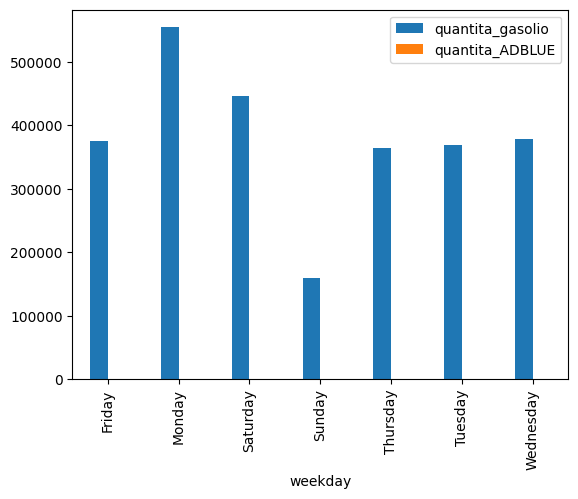

In [75]:
conn = conn_AMA
name = 'IVECO AD260S31'

gp_data = pd.read_sql(f"""SELECT * FROM mezzi_weekday WHERE mezzo_id = (
                        SELECT id FROM mezzi WHERE descrizione_mezzo = '{name}'
                    )""", conn)
del gp_data['id']
del gp_data['mezzo_id']
gp_data.plot(kind='bar', x='weekday')
plt.show()


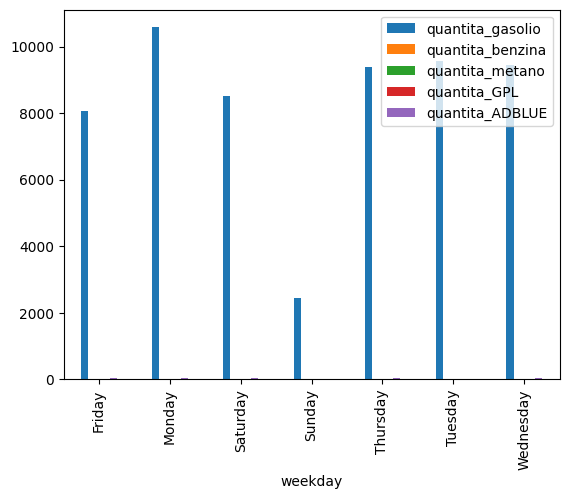

,weekday,quantita_gasolio,quantita_benzina,quantita_metano,quantita_GPL,quantita_ADBLUE
0,Friday,8073.98,0,0,0,23.00
1,Monday,10580.94,0,0,0,23.14
2,Saturday,8504.94,0,0,0,37.30
3,Sunday,2442.88,0,0,0,0.00
4,Thursday,9373.76,0,0,0,41.35
5,Tuesday,9569.96,0,0,0,20.20
6,Wednesday,9440.50,0,0,0,23.20


In [85]:
conn = conn_stradali
id = 5

gp_data = pd.read_sql(f"""SELECT * FROM mezzi_weekday WHERE mezzo_id = '{id}'""", conn)
del gp_data['id']
del gp_data['mezzo_id']
gp_data.plot(kind='bar', x='weekday')
plt.show()
gp_data